In [2]:
%pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139127 sha256=70aef1ed0005fa4f0ff8f677dcfe74a0c8c768195f0f6e9f496717008b7e4276
  Stored in directory: c:\users\jcv19\appdata\local\pip\cache\wheels\fd\fd\5e\90b9ec95da4fd6c96237b580ce74f89d6bdea547ad151ab5f4
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error




2.1 Fuentes de datos:

In [2]:
# Todos los datos necesarios se pueden obtener con estos tickers públicos:
# 1. Precio del oro (futuros)
df_oro = yf.download("GC=F", start="2010-01-01")

# 2. Índice Dólar (DXY)
df_dxy = yf.download("DX-Y.NYB", start="2010-01-01")  # Ticker correcto para DXY

# 3. Bonos 10 años (^TNX como proxy de tasas de interés)
df_bonos = yf.download("^TNX", start="2010-01-01")

# 4. Inflación (usar ETF TIP como proxy)
df_inflacion = yf.download("TIP", start="2010-01-01")  # ETF de bonos indexados a inflación

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2.2 Ingenieria de característica:

In [3]:
# Filtramos solo columnas de cierre
oro = df_oro['Close']
dxy = df_dxy['Close']
bonos = df_bonos['Close']
tip = df_inflacion['Close']

# Unimos las series
df = pd.concat([oro, dxy, bonos, tip], axis=1)
df.columns = ["Oro", "DXY", "Bonos_10y", "TIP"]

# --- Feature engineering ---
# Ratio oro/dólar
df['Ratio_Oro_Dolar'] = df['Oro'] / df['DXY']

# Inflación implícita (variación mensual de TIP)
df['Inflacion_Imp'] = df['TIP'].pct_change(periods=21, fill_method=None)

# Tasa real: Bonos - inflación implícita
df['Tasa_Real'] = df['Bonos_10y'] - df['Inflacion_Imp']

# --- SMA 200 días --- (complementario)
df['SMA_200'] = df['Oro'].rolling(window=200).mean()

# --- Bandas de Bollinger (20 días, 2 desviaciones estándar) --- (complementario)
window = 20
rolling_mean = df['Oro'].rolling(window)
rolling_std = df['Oro'].rolling(window).std()

df['Boll_Upper'] = rolling_mean.mean() + 2 * rolling_std
df['Boll_Lower'] = rolling_mean.mean() - 2 * rolling_std
df['Volatilidad'] = df['Boll_Upper'] - df['Boll_Lower']

# Eliminamos filas con valores nulos
df.dropna(inplace=True)


2.3 Ventana temporal:

In [4]:

# Features (entrada al modelo)
features = df[['Oro', 'DXY', 'Bonos_10y', 'TIP', 'Ratio_Oro_Dolar', 'Inflacion_Imp', 'Tasa_Real','SMA_200','Boll_Upper','Boll_Lower','Volatilidad']]

# Target (lo que queremos predecir)
target = df['Oro']


In [5]:

# Escalamos los features
scaler_X = RobustScaler()
scaled_features = scaler_X.fit_transform(features)

# Escalamos el target
scaler_y = RobustScaler()
scaled_target = scaler_y.fit_transform(target.values.reshape(-1, 1))


In [6]:
# Definir el tamaño de la ventana y el horizonte de predicción
lookback = 90  # 90 días de datos como entrada
forecast_horizon = 5  # 5 días futuros como salida

sequence_length = 90  # Ventana de 90 días como en el caso de estudio

# Preparamos secuencias manualmente para predecir 5 días
X_sequences = []
y_sequences = []

for i in range(len(scaled_features) - sequence_length - forecast_horizon + 1):
    # Input: ventana de 90 días
    X_sequences.append(scaled_features[i:i+sequence_length])
    
    # Output: los siguientes 5 días (horizonte de predicción)
    y_sequences.append(scaled_target[i+sequence_length:i+sequence_length+forecast_horizon].reshape(-1))

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"X shape: {X.shape}")  # Debería ser (n_samples, 90, n_features)
print(f"y shape: {y.shape}")  # Debería ser (n_samples, 5)

X shape: (2944, 90, 11)
y shape: (2944, 5)


2.4 División de los datos:

In [7]:
# División de datos: cronológica como lo pide el caso
# Calculamos los índices para la división
total_samples = len(X)
train_idx = int(total_samples * 0.7)  # 70% para entrenamiento
val_idx = int(total_samples * 0.85)   # 15% para validación, 15% para prueba

# División en conjuntos
X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
X_test, y_test = X[val_idx:], y[val_idx:]

print(f"Conjuntos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjuntos de validación: {X_val.shape}, {y_val.shape}")
print(f"Conjuntos de prueba: {X_test.shape}, {y_test.shape}")

Conjuntos de entrenamiento: (2060, 90, 11), (2060, 5)
Conjuntos de validación: (442, 90, 11), (442, 5)
Conjuntos de prueba: (442, 90, 11), (442, 5)


In [8]:
sequence_length = 30  # Ventana de 30 días

generator = TimeseriesGenerator(
    scaled_features,
    scaled_target,
    length=sequence_length,
    batch_size=32
)


In [9]:
# Número de features que estamos usando como input
n_features = scaled_features.shape[1]

# Definir la arquitectura LSTM jerárquica según el caso
model = Sequential([
    LSTM(192, input_shape=(90, n_features), return_sequences=True,
         kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
    Dropout(0.35),
    LSTM(96, return_sequences=False,
         kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
    Dense(5)
])

# Compilar modelo
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,            # reduce a 10% del valor actual
    patience=5,            # espera 5 epochs sin mejora
    min_lr=0.0001,
    verbose=1
)

c:\Users\jcv19\OneDrive\Documentos\VISUALSTUDIO\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 192)        │       156,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,133 (1.02 MB)

 Trainable params: 268,133 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\jcv19\OneDrive\Documentos\VISUALSTUDIO\.conda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7445 - mae: 0.2917
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2953 - mae: 0.1201
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1999 - mae: 0.1085
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1553 - mae: 0.1263
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1143 - mae: 0.0901
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1000 - mae: 0.1051
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0808 - mae: 0.0981
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0594 - mae: 0.0746
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0531 - mae: 0.0812
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0587 - mae: 0.1043
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0691 - mae: 0.1391
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0342 - mae: 0.0674
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/s

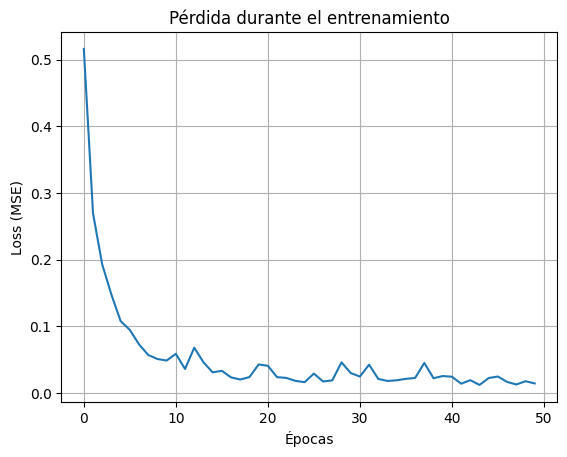

In [10]:
history = model.fit(generator, epochs=50)

plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [11]:
# Tomamos los últimos 30 días como entrada
last_sequence = scaled_features[-30:]
last_sequence = last_sequence.reshape((1, 30, n_features))

# Predecimos
pred_scaled = model.predict(last_sequence)
pred_real = scaler_y.inverse_transform(pred_scaled)

print(f"Predicción del precio del oro: {pred_real[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicción del precio del oro: 3282.26


In [13]:
# Predecimos sobre el test set
preds_scaled = model.predict(X_test)
preds_real = scaler_y.inverse_transform(preds_scaled)
y_test_real = scaler_y.inverse_transform(y_test)


# Asegúrate de que las predicciones y los valores reales tengan el mismo tamaño
print(f"Shape de preds_real: {preds_real.shape}")
print(f"Shape de y_test_real: {y_test_real.shape}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape de preds_real: (442, 5)
Shape de y_test_real: (442, 5)


In [22]:
# MAE en porcentaje
mae_percentage = np.mean(np.abs((y_test_real - preds_real) / y_test_real)) * 100

# RMSE en porcentaje
rmse_percentage = np.sqrt(np.mean((y_test_real - preds_real) ** 2)) / np.mean(y_test_real) * 100

print(f"MAE (en %): {mae_percentage:.2f}%")
print(f"RMSE (en %): {rmse_percentage:.2f}%")

MAE (en %): 3.17%
RMSE (en %): 3.97%


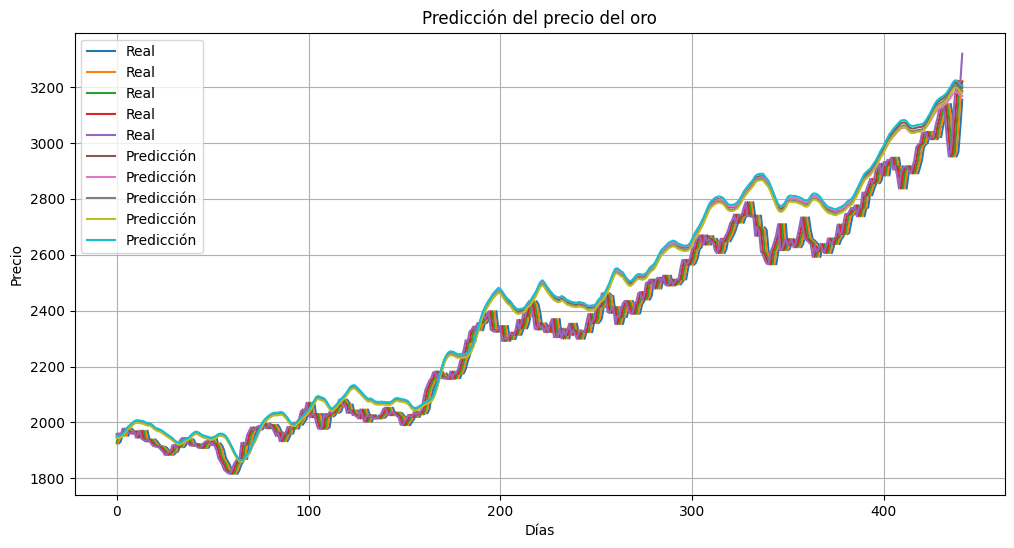

In [23]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Real')
plt.plot(preds_real, label='Predicción')
plt.legend()
plt.title('Predicción del precio del oro')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.grid(True)
plt.show()


In [25]:
import json
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

# Guardar el modelo en formato .keras
model.save("modelo_lstm_oro.keras")

# Guardamos los escaladores para las features y el target
import joblib

joblib.dump(scaler_X, 'scaler_features.joblib')  # Escalador de features
joblib.dump(scaler_y, 'scaler_target.joblib')    # Escalador de target (precio oro)

# Guardar metadata (features usadas, fechas de entrenamiento)
metadata = {
    "features_used": ["Oro", "DXY", "Bonos_10y", "TIP", "Ratio_Oro_Dolar", "Inflacion_Imp", "Tasa_Real", "SMA_200", "Boll_Upper", "Boll_Lower", "Volatilidad"],
    "training_period": "2010-01-01 a 2023-12-31"
}

# Guardar el metadata como un archivo JSON
with open("metadata.json", "w") as f:
    json.dump(metadata, f)
